In [17]:
using TaylorSeries

In [16]:
println(VERSION)

using Compat

0.4.1


In [31]:
using PyPlot

Implementamos agunas funciones entre tipos Taylor1 que necesitaremos para esolver nuestras ecuaciones diferenciales como: $tanh(x)=\frac{ e^ x - e ^{-x} }{ e^x + e ^{-x} }$, valor absoluto y la parte positiva de una función.

In [18]:
import Base.tanh
import Base.abs

In [19]:
tanh(b::Taylor1)=(exp(b)-exp(-b))/(exp(b)+exp(-b))

tanh (generic function with 14 methods)

In [20]:
tanh(Taylor1([1,2]))

 0.7615941559557649 + 0.8399486832280523 t + 𝒪(t²)

In [21]:
abs(c::Taylor1)=(c^2)^0.5

abs (generic function with 30 methods)

In [22]:
p_f(f)=(abs(f)+f)/2.0

p_f (generic function with 1 method)

Ahora haremosmás legible a running:

In [23]:
# Función Running: determina los coeficientes de la series de Taylor según las ecuaciones anteriores.
function Running{T<:Real}(vec::Array{T,1} , N::Int, t::Float64) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor
    xinT = Taylor1(vec[1], N)# Los primeros términos de la serie x0 y y0 
    xexT = Taylor1(vec[2], N)
    xMRT = Taylor1(vec[3], N)    
    rT = Taylor1(vec[4], N)
    ϕT = Taylor1(vec[5], N) 
    
    A=1.0; H=5.0; α=1.0; B=50.0; m=20; K=1 ; ω=sqrt(K/m) #K constante del resorte

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xinTt = Taylor1( xinT.coeffs[1:k+1], k)
        xexTt = Taylor1( xexT.coeffs[1:k+1], k)
        xMRTt = Taylor1( xMRT.coeffs[1:k+1], k)
        rTt = Taylor1( rT.coeffs[1:k+1], k)
        ϕTt = Taylor1( ϕT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas
        cxin = cos(xinTt)
        cxex = cos(xexTt)
        cxMR = cos(xMRTt)
        z = rTt*cos(ϕTt)
        
        p_in=p_f(cos(xinTt)) #partes positivas del coseno 
        p_ex=p_f(cos(xexTt))
        p_MR=p_f(cos(xMRTt))
        p_z=p_f(z) #parte positiva de z
       
        F=B*(p_in-p_ex) #F=B(V(xin)-V(xex))+p(t)=d(cos(xin)-cos(xex)), p=cte

        
        Dxin = 0.8808+tanh(A*cxin+α-H*p_MR) #Ahora sólo sustituimos las ecuaciones diferenciales
        Dxex = 0.8808+(A*cxex+α-H*p_in)
        DxMR = 0.8808+tanh(cxMR+H*p_z)
        Dr = -(z^2)/(m*rTt) +sin(ϕTt)*F/sqrt(m)
        Dϕ = -ω+cos(ϕTt)*F/rTt*sqrt(K*m) -sin(ϕTt)*cos(ϕTt)/m 
       
        # Los términos k+1 están determinados por (1)
        xinT.coeffs[knext+1]  = Dxin.coeffs[knext] / knext
        xexT.coeffs[knext+1]  = Dxex.coeffs[knext] / knext
        xMRT.coeffs[knext+1]  = DxMR.coeffs[knext] / knext
        rT.coeffs[knext+1]  = Dr.coeffs[knext] / knext
        ϕT.coeffs[knext+1]  = Dϕ.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xinT, xexT, xMRT, rT, ϕT]
end

Running (generic function with 1 method)

In [24]:
# Función paso: determina el tamaño de paso para la integración
# por método de Taylor.
function paso{T<:Real}(x::Taylor1{T}, epsilon::Float64)# Se introduce un polinomio de Taylor y el epsilon
    k = x.order# Orden del polinomio
    h = 1.0# Iniciamos h
    for i in [k-1, k]# Iteramos solo para los dos primeros términos del polinomio
        aux = abs( x.coeffs[i+1] )
        h = min(h, (epsilon/aux)^(1.0/i))# Nos quedamos con el mínimo
    end
    return h # La función devuelve h
end

paso (generic function with 1 method)

In [25]:
# Función evaluador: Determina los coeficientes después de cada paso.
function evaluador{T<:Real}( Eqs::Function, vec0::Array{T,1}, N::Int, epsilon::Float64, t::Float64)# La función solicita las ecuaciones
    # a resolver, un arreglo de condiciones iniciales, N que indica el máximo coeficiente de expansión y la epsilón.
    
    n = length(vec0)# Definimos algunas cantidades de utilidad
    vec1T = Eqs(vec0, N, t)# Resolvemos las ecuaciones con las condiciones iniciales
    
    # Obtenemos h para cada serie usando la función paso
    hh = vec0
    for i in eachindex(vec1T)
        hh[i] = paso(vec1T[i], epsilon)
    end
    
    # Tomamos el mínimo de los h's
    hfin = hh[1]
    for i in eachindex(hh)
        hfin = min(hfin,hh[i])
    end
    
    # Se determinan los valores del nuevo arreglo
    for i=1:n
        vec0[i] = evaluate(vec1T[i], hfin)
    end
    
    return hfin, vec0# Devolvemos los resultados
end

evaluador (generic function with 1 method)

In [26]:
# Función Integrador_1: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
   # xin0, xex0, xMR0, r0, ϕ0 =x0# Condiciones iniciales. AIXA: Te recomiendo que juegues con
    # las condiciones iniciales, aquí debe de estar el truco para obtener las gráficas que queriamos.
    
    
    tV, xinV, xexV, xMRV, rV, ϕV = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    push!(tV, t0)
    push!(xinV, xin0)# COlocamos condiciones iniciales
    push!(xexV, xex0)
    push!(xMRV, xMR0)
    push!(rV, r0)
    push!(ϕV, ϕ0)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        
        dt, res = evaluador( Running, [xin0, xex0, xMR0, r0, ϕ0], N, epsilon, t0)# Resolvemos
        t0 += dt# A t0 se le suma el tamaño de paso
        push!(tV,t0)
        push!(xinV,res[1])# Los resultados se guardan
        push!(xexV,res[2])
        push!(xMRV,res[3])# Los resultados se guardan
        push!(rV,res[4])
        push!(ϕV,res[5])
        xin0, xex0, xMR0, r0, ϕ0 = res[1], res[2], res[3], res[4], res[5]# Nuevas condiciones iniciales
    end

    return tV, xinV, xexV, xMRV, rV, ϕV# Devuelve los resultados
end

Integrador_1 (generic function with 1 method)

In [27]:
rest, resxin, resxex, resxMR, resr, resϕ = Integrador_1(500.0,Running,10.0^(-10),20,2*π,2*π,2*π,1.0,0.0);

In [28]:
function z(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
   rest, resxin, resxex, resxMR, resr, resϕ = Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, ϕ0)
   Z = resr
    for i in eachindex(resr)
    Z[i] = resr[i]*cos(resϕ[i])
end
    hcat(rest,Z)
end

z (generic function with 1 method)

In [29]:
hola=z(500.0,Running,10.0^(-10),20,2*π,2*π,2*π,1.0,0.0);

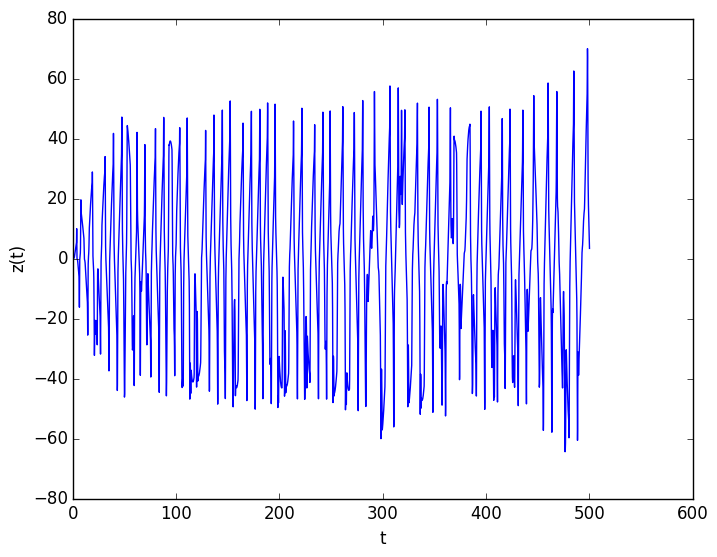

In [32]:
plot(hola[:,1],hola[:,2])
xlabel("t")
ylabel("z(t)")
legend();